#### From the paper - Kernel Density Estimation for Distributional Features


#### setup

In [27]:
import pandas as pd
import numpy as np
import warnings
from itertools import product, combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator 
import itertools
warnings.filterwarnings("ignore")

%matplotlib inline

In [28]:
def load_df_from_file(verbose=True):
    """
    Load the raw dataset with minor mods
    """
    file_path = './event_labels_1_18_2025_last_N_days.csv'
    data = pd.read_csv(file_path)
    
    if verbose is True:
        print(f"num unique artists - {len(data.act.unique())}")

    # Replace inf and -inf with NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN values
    data.dropna(inplace=True)
    
    return data

#### Run the plot for an artist pair

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, wasserstein_distance, entropy
from scipy.integrate import simps
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.ticker import ScalarFormatter, MaxNLocator

sns.set(style="whitegrid", context="paper")

#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
# Use Type 1 fonts in PDFs and set serif fonts for consistency
rcParams['pdf.use14corefonts'] = True  
#plt.rc('text', usetex=True)  # Enable LaTeX for text rendering
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
plt.rc('font', family='serif')
#plt.rc('font', serif=['Computer Modern Roman'])

fsize = 18

# globals
columns_to_plot = ['average_price', 'median_price', 'lowest_price',
                   'highest_price', 'alpha', 'beta']
label_map = {
    'average_price': r'$\mu_i$',
    'median_price': r'$\tilde{\mu}_i$',
    'lowest_price': r'$\mathrm{Min}_i$',
    'highest_price': r'$\mathrm{Max}_i$',
    'alpha': r'$\alpha_i$',
    'beta': r'$\beta_i$'
}

def run_plot():
    # Load & filter
    df = load_df_from_file()
    df_act1 = df[df.act == act1_global][["act", "date"] + columns_to_plot]
    df_act2 = df[df.act == act2_global][["act", "date"] + columns_to_plot]

    plt.figure(figsize=(15, 9))

    for i, column in enumerate(columns_to_plot, 1):
        ax = plt.subplot(2, 3, i)

        # Data
        data_act1 = df_act1[column].dropna()
        data_act2 = df_act2[column].dropna()

        # Histograms
        sns.histplot(data_act1, color='steelblue', label=act1_global,
                     stat='density', kde=False, alpha=1, linewidth=0.5)
        sns.histplot(data_act2, color='darkgray', label=act2_global,
                     stat='density', kde=False, alpha=1, linewidth=0.5)

        # KDE
        kde1 = gaussian_kde(data_act1)
        kde2 = gaussian_kde(data_act2)
        x_grid = np.linspace(min(data_act1.min(), data_act2.min()) - 1,
                             max(data_act1.max(), data_act2.max()) + 1, 1000)
        p = kde1.evaluate(x_grid)
        q = kde2.evaluate(x_grid)
        p /= simps(p, x_grid)
        q /= simps(q, x_grid)

        # Distances
        w_distance = wasserstein_distance(data_act1, data_act2)
        hellinger_integral = simps((np.sqrt(p) - np.sqrt(q))**2, x_grid)
        hellinger_distance = (1 / np.sqrt(2)) * np.sqrt(hellinger_integral)
        m = 0.5 * (p + q)
        eps = 1e-10
        p_safe = np.where(p == 0, eps, p)
        q_safe = np.where(q == 0, eps, q)
        m_safe = np.where(m == 0, eps, m)
        kl_p_m = entropy(p_safe, m_safe)
        kl_q_m = entropy(q_safe, m_safe)
        js_divergence = 0.5 * (kl_p_m + kl_q_m)
        js_distance = np.sqrt(js_divergence)

        ax.plot(x_grid, p, color="navy", linestyle='-', linewidth=2)
        ax.plot(x_grid, q, color="#3b3b3b", linestyle='-', linewidth=2)
        #ax.plot(x_grid, q, color="darkgray", linestyle='-', linewidth=2)

        # — smart tick formatting —
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
        # Access and modify the offset text (the "×10³" part)
        offset = ax.xaxis.get_offset_text()
        offset.set_fontsize(fsize)
        
        ax.xaxis.set_major_locator(MaxNLocator(nbins=4))

        # Labels & legend (exactly as before)
        if column == "alpha":
            ax.legend(loc='upper right', frameon=False, fontsize=fsize-1)

        ax.set_xlabel(
            f"{label_map[column]}\n\n  Hell Dist: {hellinger_distance:.4f} - JS Div: {js_divergence:.4f}",
            fontsize=fsize
        )
        ax.set_ylabel("Density", fontsize=fsize)
        ax.tick_params(axis='x', labelsize=fsize)
        ax.tick_params(axis='y', labelsize=fsize)

    plt.tight_layout()
    plt.savefig(
        #'kde_alpha_beta_params.eps',
        'kde_alpha_beta_params_Dropkick_Murphys.eps',
        format='eps',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

#### Draw

num unique artists - 955


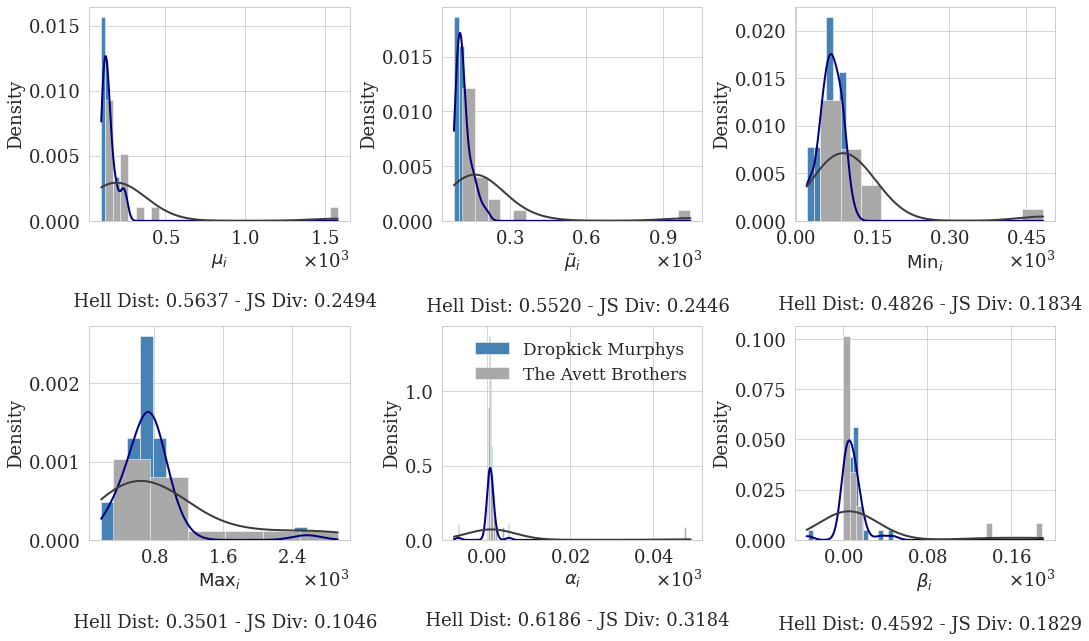

In [30]:
# act1_global = "Toosii"
# act2_global = "Veeze"

# act1_global = "Drake"
# act2_global = "Olivia Rodrigo"

act1_global = "Dropkick Murphys"
act2_global = "The Avett Brothers"

# act1_global = "Ed Sheeran"
# act2_global = "Beyonce"

run_plot()